In [1]:
import sys,os,glob,copy
sys.path.append('../')
import numpy as np
from numpy.linalg import norm
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
from scipy.interpolate import LinearNDInterpolator,interp2d
import matplotlib as mpl
from matplotlib.colors import LogNorm
from IPython.display import display, Markdown
import glob
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "sans-serif",
    "font.sans-serif": ["Helvetica"]})

plt.rcParams.update({"savefig.dpi" : 300}) #Figure resolution


#Define plotting style:
sns.set() #Set style
sns.set_style('ticks',{'font.family':'Times New Roman', 'font.serif':'Times New Roman'})
sns.set_context('paper', font_scale=1.8)
cm = plt.cm.get_cmap('RdYlBu')


pd.set_option('display.max_rows', 200)

### Load CMS CutFlow

In [2]:
cmsData = pd.read_pickle('../AuxInfo/CMS-EXO-20-004-data/DMsimp_spin-1_Monojet_DF.pcl')
cmsData['filename'] = 'CMS'

### Add recast samples

In [3]:
files = { 
#           'all' : '../DMSimp_axial_all/Events/run_01/axial_cms_exo_20_004.pcl'
          'all' : '../DMSimp_axial_all/Events/run_07/axial_cms_exo_20_004.pcl'
#           'all' : '../DMSimp_axial_all/Events/run_03/axial_500_1_cms_exo_20_004.pcl'
        }


allData = cmsData
for label,f in files.items():
    recastData = pd.read_pickle(f)
    recastData['filename'] = label
    allData = pd.concat((allData,recastData))
    
allData.sort_values(['Coupling','Mode','$m_{med}$','$m_{DM}$','Data-takingperiod'],inplace=True,
              ascending=[False,False,True,True,False])    

In [4]:
modelData = recastData[['Coupling','Mode','$m_{med}$','$m_{DM}$','$g_{DM}$','$g_{q}$','Data-takingperiod']]
dfModel = allData.merge(modelData,how='right')

In [5]:
dfModel.T

,0,1
Coupling,Axial,Axial
Mode,DM+QCDjets,DM+QCDjets
$m_{med}$,500.0,500.0
$m_{DM}$,1.0,1.0
$g_{DM}$,1.0,1.0
$g_{q}$,0.25,0.25
Data-takingperiod,2017,2017
Fullsample,1.0,1.0
Triggeremulation,0.88472,0.898964
$p_{T}^{miss}>250$GeV,0.34167,0.273748


### Get MET bins

In [6]:
bins = {c : eval(c.split('_')[1]) for c in dfModel.columns if ("bin_" in c and not 'Error' in c)}
binsError = {c : eval(c.split('_')[1]) for c in dfModel.columns if ("bin_" in c and 'ErrorPlus' in c)}
data = {}
dataError = {}
for fname in dfModel['filename']:
    data[os.path.basename(fname)] = {c : dfModel[dfModel['filename'] == fname][c].iloc[0] 
                                     for c in bins}
    dataError[os.path.basename(fname)] = {c : dfModel[dfModel['filename'] == fname][c].iloc[0] 
                                         for c in binsError}
    
rightBin = 2000.
binCenter = (np.array(list(bins.values()))+np.diff(list(bins.values())+[rightBin])/2).tolist()    
binLeft = [bins[c] for c in bins]+[rightBin]

### Compute k-factors

In [7]:
# Define k-factors so the signal yield summed over all
# MET bins equals CMS
totCMS = sum(data['CMS'].values())
kfactors = {label : totCMS/sum(data[label].values()) for label in data}

### Plot MET bins

/tmp/ipykernel_79116/2184136848.py:24: RuntimeWarning: divide by zero encountered in divide
  relDiffErr = np.abs(weights-weightsCMS)/error


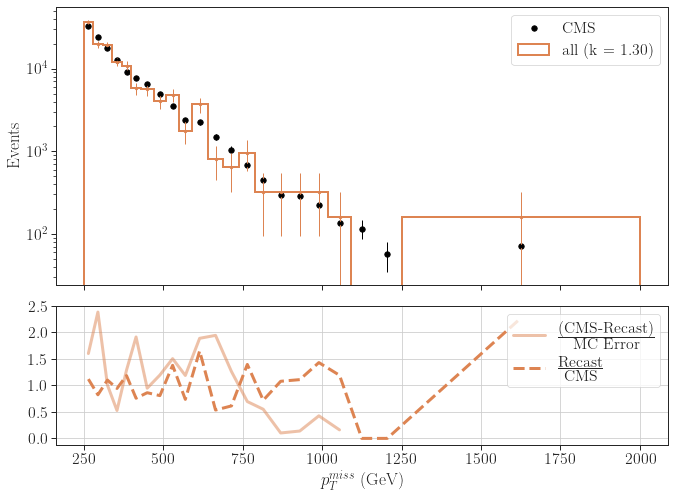

In [8]:
f, axarr = plt.subplots(2,sharex=True, gridspec_kw = {'height_ratios':[2, 1]},figsize=(10,8))
plt.subplots_adjust(left=0.12, bottom=0.12, right=0.97, top=None, wspace=None, hspace=0.1)
colors = {label : sns.color_palette('deep')[i] for i,label in enumerate(data.keys())}    
colors['CMS'] = 'black'
weightsCMS = np.array([data['CMS'][c] for c in bins])

first = True
for label in data:    
    kfactor = kfactors[label]
    weights = kfactor*np.array([data[label][c] for c in bins])
    error = kfactor*np.array([dataError[label][c] for c in binsError])    
    if label == 'CMS':        
        axarr[0].scatter(x=binCenter,y=weights,s=30,c=colors[label],label=label)
    else:
        axarr[0].hist(binCenter,bins=binLeft,
                       label=label+' (k = %1.2f)' %kfactor,linewidth=2,
                       weights=weights,histtype='step',
                      color=colors[label])
        
        
        
        relDiff = (weights-weightsCMS)/weightsCMS
        ratio = weights/weightsCMS
        relDiffErr = np.abs(weights-weightsCMS)/error
        #Plot ratio
        if first:
            label1 = r'$\frac{\mbox{(CMS-Recast)}}{\mbox{MC Error}}$'
            label2 = r'$\frac{\mbox{Recast}}{\mbox{CMS}}$'
            first = False
        else:
            label1 = None
            label2 = None
        axarr[1].plot(binCenter,relDiffErr,linewidth=3.0,color=colors[label],
                      label=label1,alpha=0.5)
        axarr[1].plot(binCenter,ratio,linewidth=3.0,color=colors[label],linestyle='--', 
                      label=label2)        

    axarr[0].errorbar(binCenter,weights,yerr = error, marker = '.', elinewidth=1.0,
             drawstyle = 'steps-mid',linewidth=0.0,color=colors[label])
    
    
axarr[1].set_yticks([0.,0.5,1.0,1.5,2.0,2.5])
axarr[1].grid(True)
axarr[1].set_xlabel(r'$p_{T}^{miss}$ (GeV)')
axarr[0].set_yscale('log')
axarr[0].set_ylabel('Events')
axarr[0].legend()
axarr[1].legend()
# axarr[0].set_ylim(1e-2,1e3)
# axarr[0].set_xlim(250,1000)
# axarr[1].set_ylim(0.5,1.5)
# axarr[0].set_title('k-factor = %1.2f' %kfactor)
plt.show()
